<a href="https://colab.research.google.com/github/TIANBOQIU/AppliedDeepLearning/blob/master/HW2_v0_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install -q tf-nightly-2.0-preview

In [43]:
from __future__ import absolute_import, division, print_function
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import os
import numpy as np
import zipfile

from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import ResNet50, InceptionV3

print(tf.__version__)

2.0.0-dev20190214


In [3]:
!wget https://storage.googleapis.com/applied-dl/mini_flowers.zip \
  -O /tmp/mini_flowers.zip

--2019-02-14 22:44:43--  https://storage.googleapis.com/applied-dl/mini_flowers.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.206.128, 2a00:1450:400c:c04::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.206.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 40110537 (38M) [application/zip]
Saving to: ‘/tmp/mini_flowers.zip’

/tmp/mini_flowers.z 100%[===================>]  38.25M  24.2MB/s    in 1.6s    

2019-02-14 22:44:45 (24.2 MB/s) - ‘/tmp/mini_flowers.zip’ saved [40110537/40110537]



In [4]:
# Data
local_zip = '/tmp/mini_flowers.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/mini_flowers')
zip_ref.close()
base_dir = '/tmp/mini_flowers'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
n_classes = len(os.listdir(train_dir))
train_paths = [os.path.join(train_dir, i) for i in os.listdir(train_dir)]
val_paths = [os.path.join(val_dir, i) for i in os.listdir(val_dir)]
n_train = sum([len(os.listdir(i)) for i in train_paths])
n_val = sum([len(os.listdir(i)) for i in val_paths])
data_gen = ImageDataGenerator(rescale=1./255)
BATCH_SIZE=32
TARGET_SHAPE=150
train_data = data_gen.flow_from_directory(batch_size=BATCH_SIZE,
                                         directory=train_dir,
                                         shuffle=True,
                                         target_size=(TARGET_SHAPE,TARGET_SHAPE),
                                         class_mode='categorical')
val_data = data_gen.flow_from_directory(batch_size=BATCH_SIZE,
                                         directory=val_dir,
                                         shuffle=True,
                                         target_size=(TARGET_SHAPE,TARGET_SHAPE),
                                         class_mode='categorical')



Found 1000 images belonging to 5 classes.
Found 500 images belonging to 5 classes.


In [7]:
batch_train_images, batch_train_labels = next(train_data)
batch_train_images.shape
batch_train_labels[4]
train_data.batch_size

32

In [0]:
# feature extraction
conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(150,150,3))

def extract_features(data_gen, sample_count):
  features = np.zeros(shape=(sample_count, 4, 4, 512))
  labels = np.zeros(shape=(sample_count,5))
  i = 0
  BATCH_SIZE = data_gen.batch_size
  for images_batch, labels_batch in data_gen:
    features[i*BATCH_SIZE: (i+1)*BATCH_SIZE] = conv_base.predict(images_batch)
    labels[i*BATCH_SIZE: (i+1)*BATCH_SIZE] = labels_batch
    i += 1
    if i * BATCH_SIZE >= sample_count:
      break
    return features, labels
train_features, train_labels = extract_features(train_data, n_train)
val_features, val_labels = extract_features(val_data, n_val)

In [17]:
print(train_features.shape)
print(train_labels.shape)

(1000, 4, 4, 512)
(1000, 5)


In [25]:
# Model
train_features = np.reshape(train_features, (n_train, 4*4*512))
val_features = np.reshape(val_features, (n_val, 4*4*512))
model = Sequential()
model.add(Dense(256, activation='relu', input_dim=4*4*512))
model.add(keras.layers.Dropout(0.5))
model.add(Dense(5, activation = 'sigmoid'))

model.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics = ['acc'])
history = model.fit(train_features, train_labels, epochs=20,batch_size=32, validation_data=(val_features, val_labels))

Train on 1000 samples, validate on 500 samples
Epoch 1/20
1000/1000==============================] - 1s 875us/sample - loss: 0.0759 - acc: 0.0720 - val_loss: 0.0976 - val_acc: 0.0160
Epoch 2/20
1000/1000==============================] - 1s 661us/sample - loss: 0.0510 - acc: 0.3510 - val_loss: 0.1022 - val_acc: 0.9520
Epoch 3/20
1000/1000==============================] - 1s 675us/sample - loss: 0.0437 - acc: 0.3890 - val_loss: 0.1694 - val_acc: 0.0160
Epoch 4/20
1000/1000==============================] - 1s 666us/sample - loss: 0.0630 - acc: 0.6360 - val_loss: 0.2483 - val_acc: 0.9540
Epoch 5/20
1000/1000==============================] - 1s 659us/sample - loss: 0.0523 - acc: 0.9750 - val_loss: 0.1409 - val_acc: 0.9500
Epoch 6/20
1000/1000==============================] - 1s 660us/sample - loss: 0.0397 - acc: 0.9750 - val_loss: 0.1432 - val_acc: 0.9500
Epoch 7/20
1000/1000==============================] - 1s 657us/sample - loss: 0.0407 - acc: 0.9410 - val_loss: 0.1276 - val_acc: 0.9540
E

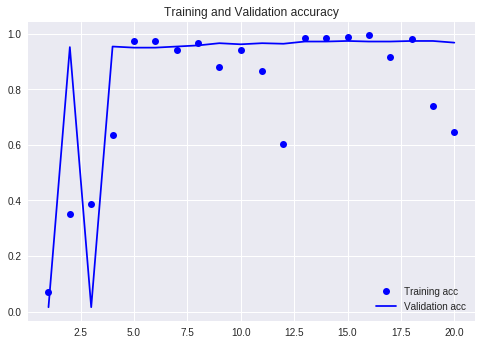

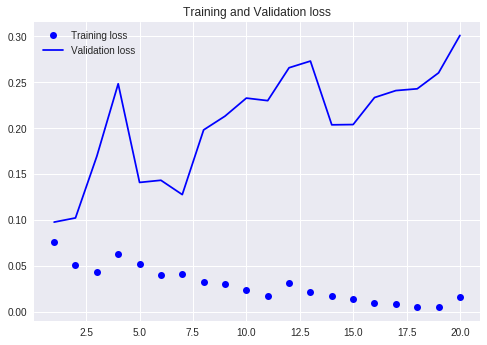

In [26]:
# Plotting the results
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc)+1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and Validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()


**The validation accuracy is 96.80% in this model.**

**Part 1.2**

In [0]:
def extract_features_for_ResNet50(data_gen, sample_count):
  features = np.zeros(shape=(sample_count, 5, 5, 2048))
  labels = np.zeros(shape=(sample_count,5))
  i = 0
  BATCH_SIZE = data_gen.batch_size
  for images_batch, labels_batch in data_gen:
    features[i*BATCH_SIZE: (i+1)*BATCH_SIZE] = conv_base.predict(images_batch)
    labels[i*BATCH_SIZE: (i+1)*BATCH_SIZE] = labels_batch
    i += 1
    if i * BATCH_SIZE >= sample_count:
      break
    return features, labels
train_features, train_labels = extract_features_for_ResNet50(train_data, n_train)
val_features, val_labels = extract_features_for_ResNet50(val_data, n_val)
train_features = np.reshape(train_features, (n_train, 5 * 5 * 2048))
val_features = np.reshape(val_features, (n_val, 5 * 5 * 2048))

In [32]:
# Transfer from ResNet50

conv_base = ResNet50(weights='imagenet', include_top=False, input_shape=(150,150,3))

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


94658560/94653016==============================] - 4s 0us/step


In [33]:
conv_base.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 156, 156, 3)  0           input_6[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 75, 75, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalizationV1) (None, 75, 75, 64)   256         conv1[0][0]                      
___________________________________________________________________________________________

In [41]:
model2 = Sequential()
model2.add(Dense(256, activation='relu', input_dim=5*5*2048))
model2.add(keras.layers.Dropout(0.5))
model2.add(Dense(5, activation='sigmoid'))
model2.compile(optimizer='adam',
             loss='categorical_crossentropy',
             metrics=['acc'])
checkpoint_path = 'training/cp-{epoch:04d}.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                verbose = 1,
                                                save_weights_only=True,
                                                period=1)
history2 = model2.fit(train_features, train_labels, epochs=20,batch_size=32,callbacks=[cp_callback], validation_data=(val_features, val_labels))

Train on 1000 samples, validate on 500 samples
Epoch 1/20
 992/1000============================>.] - ETA: 0s - loss: 0.1198 - acc: 0.1280
Epoch 00001: saving model to training/cp-0001.ckpt
1000/1000==============================] - 5s 5ms/sample - loss: 0.1286 - acc: 0.1280 - val_loss: 0.1038 - val_acc: 0.0100
Epoch 2/20
 992/1000============================>.] - ETA: 0s - loss: 0.0735 - acc: 0.0060
Epoch 00002: saving model to training/cp-0002.ckpt
1000/1000==============================] - 4s 4ms/sample - loss: 0.0729 - acc: 0.0060 - val_loss: 0.1030 - val_acc: 0.0140
Epoch 3/20
 992/1000============================>.] - ETA: 0s - loss: 0.0524 - acc: 0.1280
Epoch 00003: saving model to training/cp-0003.ckpt
1000/1000==============================] - 4s 4ms/sample - loss: 0.0520 - acc: 0.1280 - val_loss: 0.1030 - val_acc: 0.0180
Epoch 4/20
 992/1000============================>.] - ETA: 0s - loss: 0.0482 - acc: 0.4163
Epoch 00004: saving model to training/cp-0004.ckpt
1000/1000=======

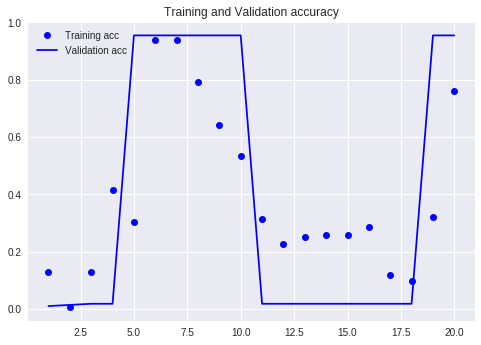

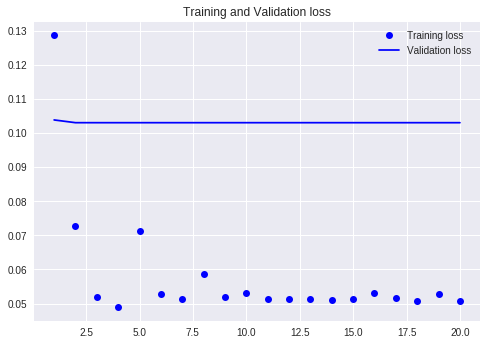

In [42]:
# Plotting the results
acc = history2.history['acc']
val_acc = history2.history['val_acc']
loss = history2.history['loss']
val_loss = history2.history['val_loss']
epochs = range(1, len(acc)+1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and Validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [44]:
# Transfer from InceptionV3
conv_base = InceptionV3(weights='imagenet', include_top=False, input_shape=(150,150,3))


87916544/87910968==============================] - 6s 0us/step


In [45]:
conv_base.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_7[0][0]                    
__________________________________________________________________________________________________
batch_normalization_v1 (BatchNo (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation_49 (Activation)      (None, 74, 74, 32)   0           batch_normalization_v1[0][0]     
_______________________________________________________________________________________

In [46]:
len(conv_base.layers) #the network is very deep

311

In [0]:
def extract_features_for_InceptionV3(data_gen, sample_count):
  features = np.zeros(shape=(sample_count, 3, 3, 2048))
  labels = np.zeros(shape=(sample_count,5))
  i = 0
  BATCH_SIZE = data_gen.batch_size
  for images_batch, labels_batch in data_gen:
    features[i*BATCH_SIZE: (i+1)*BATCH_SIZE] = conv_base.predict(images_batch)
    labels[i*BATCH_SIZE: (i+1)*BATCH_SIZE] = labels_batch
    i += 1
    if i * BATCH_SIZE >= sample_count:
      break
    return features, labels
train_features, train_labels = extract_features_for_InceptionV3(train_data, n_train)
val_features, val_labels = extract_features_for_InceptionV3(val_data, n_val)
train_features = np.reshape(train_features, (n_train, 3 * 3 * 2048))
val_features = np.reshape(val_features, (n_val, 3 * 3 * 2048))

In [49]:
model3 = Sequential()
model3.add(Dense(256, activation='relu', input_dim=3*3*2048))
model3.add(keras.layers.Dropout(0.5))
model3.add(Dense(5, activation='sigmoid'))
model3.compile(optimizer='adam',
             loss='categorical_crossentropy',
             metrics=['acc'])
checkpoint_path = 'trainingV3/cp-{epoch:04d}.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                verbose = 1,
                                                save_weights_only=True,
                                                period=1)
history3 = model3.fit(train_features, train_labels, epochs=20,batch_size=32,callbacks=[cp_callback], validation_data=(val_features, val_labels))

Train on 1000 samples, validate on 500 samples
Epoch 1/20
 992/1000============================>.] - ETA: 0s - loss: 0.2110 - acc: 0.1623
Epoch 00001: saving model to trainingV3/cp-0001.ckpt
1000/1000==============================] - 1s 1ms/sample - loss: 0.2254 - acc: 0.1610 - val_loss: 0.4840 - val_acc: 0.0040
Epoch 2/20
 960/1000===========================>..] - ETA: 0s - loss: 0.2340 - acc: 0.0385
Epoch 00002: saving model to trainingV3/cp-0002.ckpt
1000/1000==============================] - 2s 2ms/sample - loss: 0.2246 - acc: 0.0370 - val_loss: 0.2360 - val_acc: 0.0060
Epoch 3/20
 960/1000===========================>..] - ETA: 0s - loss: 0.1956 - acc: 0.0219
Epoch 00003: saving model to trainingV3/cp-0003.ckpt
1000/1000==============================] - 2s 2ms/sample - loss: 0.1892 - acc: 0.0210 - val_loss: 0.4892 - val_acc: 0.0060
Epoch 4/20
 960/1000===========================>..] - ETA: 0s - loss: 0.2416 - acc: 0.1083
Epoch 00004: saving model to trainingV3/cp-0004.ckpt
1000/100

In [51]:
model3.load_weights('trainingV3/cp-0019.ckpt')
loss, acc = model3.evaluate(val_features, val_labels) # The highest accuracy we got is 94.20%

500/500==============================] - 0s 378us/sample - loss: 0.2320 - acc: 0.9420


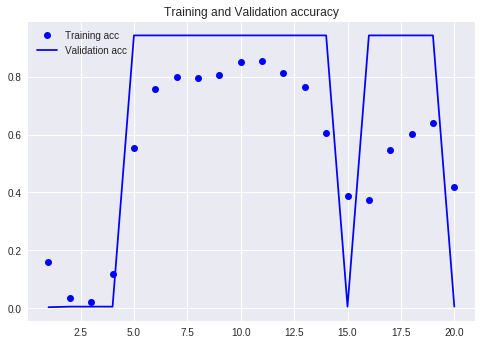

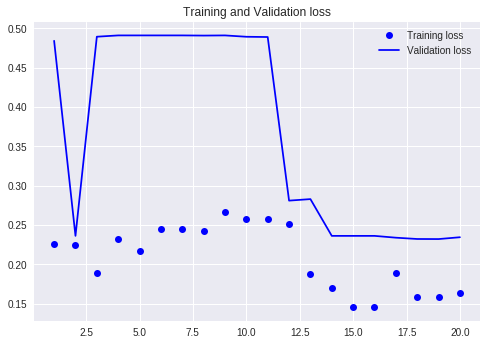

In [52]:
# Plotting the results
acc = history3.history['acc']
val_acc = history3.history['val_acc']
loss = history3.history['loss']
val_loss = history3.history['val_loss']
epochs = range(1, len(acc)+1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and Validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

##Comparison
$\bullet$ **accuracy** $VGG16 : 96.80\%, ResNet50 : 95.40\%, InceptionV3 : 94.20\%$

$\bullet$ When deeper conv_base is used, it takes longer for the model to overfit. 

$\bullet$ We can also see that the deeper model has less accuracy, probably because the deeper model learned more abstract features and needs more data for training.

#Part 2